In [1]:
import numpy as np
import json
import torch
from pprint import pprint

from hnet.models.mixer_seq import HNetForCausalLM
from hnet.models.config_hnet import (
    AttnConfig,
    SSMConfig,
    HNetConfig,
)

model_config_path = "configs/hnet_2stage_L.json"

In [2]:
with open(model_config_path, "r") as f:
    config = json.load(f)

# Create config objects
attn_cfg = AttnConfig(**config.pop("attn_cfg"))
ssm_cfg = SSMConfig(**config.pop("ssm_cfg"))
hnet_cfg = HNetConfig(**config, attn_cfg=attn_cfg, ssm_cfg=ssm_cfg)
print(attn_cfg)
print(ssm_cfg)
pprint(hnet_cfg)

AttnConfig(num_heads=[16, 16, 16], rotary_emb_dim=[32, 32, 48], window_size=[1023, 1023, -1])
SSMConfig(d_conv=4, expand=2, d_state=128, chunk_size=256)
HNetConfig(arch_layout=['m4', ['T1m4', ['T26'], 'm4T1'], 'm4'],
           d_model=[1024, 1024, 1536],
           d_intermediate=[0, 2816, 4096],
           vocab_size=256,
           ssm_cfg=SSMConfig(d_conv=4, expand=2, d_state=128, chunk_size=256),
           attn_cfg=AttnConfig(num_heads=[16, 16, 16],
                               rotary_emb_dim=[32, 32, 48],
                               window_size=[1023, 1023, -1]),
           tie_embeddings=False)


In [3]:
# Create model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HNetForCausalLM(hnet_cfg, device=device, dtype=torch.bfloat16)
model

HNetForCausalLM(
  (embeddings): Embedding(256, 1024)
  (backbone): HNet(
    (encoder): Isotropic(
      (layers): ModuleList(
        (0-3): 4 x Block(
          (norm1): RMSNorm()
          (mixer): Mamba2Wrapper(
            (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
            (conv1d): Conv1d(2304, 2304, kernel_size=(4,), stride=(1,), padding=(3,), groups=2304)
            (act): SiLU()
            (norm): RMSNorm()
            (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
          )
        )
      )
      (rmsnorm): RMSNorm()
    )
    (main_network): HNet(
      (encoder): Isotropic(
        (layers): ModuleList(
          (0): Block(
            (norm1): RMSNorm()
            (mixer): CausalMHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): Linear(in_features=1024, out_features=3072, bias=False)
              (inner_attn): FlashCausalSelfAttention()
              (inner_cross_attn): FlashCausalCrossAttentio

In [4]:
# Calculate number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.2f}M")

Total number of parameters: 874.32M


In [5]:
# from hnet.utils.train import load_balancing_loss

# load_balancing_loss(routing_module, N=3)

In [6]:
from hnet.utils.tokenizers import ByteTokenizer

prompt = "Hello, my name is"

tokenizer = ByteTokenizer()
encoded = tokenizer.encode([prompt], add_bos=True)[0]
input_ids_BxL = torch.tensor(
    encoded["input_ids"], dtype=torch.long, device=device
).unsqueeze(0)
print(input_ids_BxL)
input_ids_BxL.shape

tensor([[254,  72, 101, 108, 108, 111,  44,  32, 109, 121,  32, 110,  97, 109,
         101,  32, 105, 115]], device='cuda:0')


torch.Size([1, 18])

In [7]:
mask = torch.ones(input_ids_BxL.shape, device=device, dtype=torch.bool)
output = model.forward(input_ids_BxL, mask=mask)
logits_BxLxV = output.logits
bpred = output.bpred_output

In [8]:
logits_BxLxV.shape

torch.Size([1, 18, 256])

In [9]:
bpred

[RoutingModuleOutput(boundary_prob=tensor([[[0.0000, 1.0000],
          [0.5195, 0.4805],
          [0.5000, 0.5000],
          [0.5195, 0.4805],
          [0.8477, 0.1523],
          [0.4844, 0.5156],
          [0.4961, 0.5039],
          [0.4883, 0.5117],
          [0.4961, 0.5039],
          [0.5469, 0.4512],
          [0.5156, 0.4863],
          [0.5430, 0.4570],
          [0.4844, 0.5156],
          [0.5000, 0.4980],
          [0.4883, 0.5117],
          [0.5234, 0.4785],
          [0.5000, 0.5000],
          [0.5156, 0.4844]]], device='cuda:0', dtype=torch.bfloat16,
        grad_fn=<StackBackward0>), boundary_mask=tensor([[ True, False, False, False, False,  True,  True,  True,  True, False,
          False, False,  True, False,  True, False, False, False]],
        device='cuda:0'), selected_probs=tensor([[[1.0000],
          [0.5195],
          [0.5000],
          [0.5195],
          [0.8477],
          [0.5156],
          [0.5039],
          [0.5117],
          [0.5039],
     

In [10]:
bpred[0].boundary_prob

tensor([[[0.0000, 1.0000],
         [0.5195, 0.4805],
         [0.5000, 0.5000],
         [0.5195, 0.4805],
         [0.8477, 0.1523],
         [0.4844, 0.5156],
         [0.4961, 0.5039],
         [0.4883, 0.5117],
         [0.4961, 0.5039],
         [0.5469, 0.4512],
         [0.5156, 0.4863],
         [0.5430, 0.4570],
         [0.4844, 0.5156],
         [0.5000, 0.4980],
         [0.4883, 0.5117],
         [0.5234, 0.4785],
         [0.5000, 0.5000],
         [0.5156, 0.4844]]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<StackBackward0>)

In [11]:
bpred[1].boundary_prob

tensor([[[0.0000, 1.0000],
         [0.5312, 0.4668],
         [0.5156, 0.4824],
         [0.4844, 0.5156],
         [0.5000, 0.5000],
         [0.5312, 0.4688],
         [0.5469, 0.4551]]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<StackBackward0>)

In [12]:
probs_BxLxV = torch.softmax(logits_BxLxV, dim=-1)
probs_BxLxV.shape

torch.Size([1, 18, 256])

In [13]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]

# Example: Print the first sample
print(train_data[0]["text"])
print("Label:", train_data[0]["label"])

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 2


In [14]:
# Extract text and concatenate into one giant, raw string (unsafe for real LLM pretraining)
all_train_texts = [doc["text"] for doc in train_data]

In [15]:
# # DATASET PREPARATION
# raw_train_text = [
#     "Hello, my name is Alice. I love programming in Python.",
#     "The quick brown fox jumps over the lazy dog.",
#     "Sleep Token is an English rock band formed in London in 2016.",
# ]

In [16]:
encoded_inputs = tokenizer.encode(all_train_texts, add_bos=True, add_eos=True)
encoded_inputs_ids = [ids["input_ids"] for ids in encoded_inputs]
input_ids_list = [
    torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)
    for ids in encoded_inputs_ids
]
print(input_ids_list[0])

tensor([[254,  87,  97, 108, 108,  32,  83, 116,  46,  32,  66, 101,  97, 114,
         115,  32,  67, 108,  97, 119,  32,  66,  97,  99, 107,  32,  73, 110,
         116, 111,  32, 116, 104, 101,  32,  66, 108,  97,  99, 107,  32,  40,
          82, 101, 117, 116, 101, 114, 115,  41,  32,  82, 101, 117, 116, 101,
         114, 115,  32,  45,  32,  83, 104, 111, 114, 116,  45, 115, 101, 108,
         108, 101, 114, 115,  44,  32,  87,  97, 108, 108,  32,  83, 116, 114,
         101, 101, 116,  39, 115,  32, 100, 119, 105, 110, 100, 108, 105, 110,
         103,  92,  98,  97, 110, 100,  32, 111, 102,  32, 117, 108, 116, 114,
          97,  45,  99, 121, 110, 105,  99, 115,  44,  32,  97, 114, 101,  32,
         115, 101, 101, 105, 110, 103,  32, 103, 114, 101, 101, 110,  32,  97,
         103,  97, 105, 110,  46, 255]], device='cuda:0')


In [17]:
longest_len = max(len(ids) for ids in encoded_inputs_ids)
shortest_len = min(len(ids) for ids in encoded_inputs_ids)
avg_len = sum(len(ids) for ids in encoded_inputs_ids) / len(encoded_inputs_ids)
print(f"Longest sequence length: {longest_len}")
print(f"Shortest sequence length: {shortest_len}")
print(f"Average sequence length: {avg_len:.2f}")

Longest sequence length: 1014
Shortest sequence length: 102
Average sequence length: 238.48


In [18]:
input_len = 256
# filter out sequences longer shorter than input_len
# trim longer sequences, everything to input_len
training_data = []
for ids in input_ids_list:
    if ids.shape[1] < input_len:
        continue
    elif ids.shape[1] > input_len:
        ids = ids[:, :input_len]
    training_data.append(ids)


print(f"Number of training samples: {len(training_data)}")

training_data = torch.utils.data.ConcatDataset(training_data)

batched_training_data = torch.utils.data.DataLoader(
    training_data, batch_size=128, shuffle=True
)

next(iter(batched_training_data)).shape

Number of training samples: 40123


torch.Size([128, 256])

In [19]:
# This is vibecoded
import torch
from torch.nn import Parameter
from collections import defaultdict
from tqdm import tqdm
from hnet.utils.train import (
    load_balancing_loss,
    group_params,
    apply_optimization_params,
)

# 1. DEFINE YOUR SETTINGS
BASE_LR = 6.25e-4  # for L scale
WEIGHT_DECAY = 0.1

# For a 2-stage model (S=2), we need S+1=3 multipliers:
# [mult_stage_0 (outer), mult_stage_1 (middle), mult_main_net (inner)]
# Outer stages get higher LRs [cite: 291-295, 1433-1438].
lr_multipliers = [2.0, 1.5, 1.0]
num_stages = len(
    model.backbone.encoder.layers
)  # This is a bit of a hack, assumes S=len(encoders)
# A better check for S=2:
assert hasattr(model.backbone.main_network, "encoder"), "Model is not S=2"
assert len(lr_multipliers) == 3, "Expecting 3 LR multipliers for S=2 model"


# 2. PRE-ANNOTATE PARAMETERS (The corrected part)
print("Pre-annotating model parameters with LR multipliers...")
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue

    # Default: main network LR (innermost)
    current_lr_mult = lr_multipliers[2]  # lr_multipliers[S]

    # --- Stage 0 (S=0, outermost) ---
    if (
        name.startswith("embeddings")
        or name.startswith("lm_head")
        or name.startswith("backbone.encoder")
        or name.startswith("backbone.decoder")
        or name.startswith("backbone.routing_module")
        or name.startswith("backbone.chunk_layer")
        or name.startswith("backbone.dechunk_layer")
        or name.startswith("backbone.residual_proj")
    ):
        current_lr_mult = lr_multipliers[0]

    # --- Stage 1 (S=1, middle) ---
    elif (
        name.startswith("backbone.main_network.encoder")
        or name.startswith("backbone.main_network.decoder")
        or name.startswith("backbone.main_network.routing_module")
        or name.startswith("backbone.main_network.chunk_layer")
        or name.startswith("backbone.main_network.dechunk_layer")
        or name.startswith("backbone.main_network.residual_proj")
    ):
        current_lr_mult = lr_multipliers[1]

    # --- Main Network (M, innermost) ---
    elif name.startswith("backbone.main_network.main_network"):
        # This is the final M network
        current_lr_mult = lr_multipliers[2]

    # Apply the LR multiplier
    apply_optimization_params(param, lr_mult=current_lr_mult)

# 3. NOW, CALL THE "ORIGINAL" GROUP_PARAMS FUNCTION
# It will find the `lr_mult` you just added and group by it.
# It will also add `weight_decay=0.0` to biases/norms.
gparams = group_params(model)

# 4. YOUR ORIGINAL CALLER CODE (This part was correct)
print(f"Created {len(gparams)} optimizer param groups:")
for i, g in enumerate(gparams):
    n = sum(p.numel() for p in g["params"])
    lr_str = g.get("lr_mult", "default")
    wd_str = g.get("weight_decay", "default_wd")
    print(f"  group {i}: params={n / 1e6:.2f}M, lr_mult={lr_str}, wd={wd_str}")

# Convert lr_mult to absolute lr
for g in gparams:
    if "lr_mult" in g:
        g["lr"] = BASE_LR * g.pop("lr_mult")
    # Set default WD for groups that don't have it (i.e., not biases/norms)
    if "weight_decay" not in g:
        g["weight_decay"] = WEIGHT_DECAY

# Use groups with AdamW
optimizer = torch.optim.AdamW(gparams, lr=BASE_LR, weight_decay=WEIGHT_DECAY)

print("\nOptimizer groups are set up and ready.")

Pre-annotating model parameters with LR multipliers...
Created 5 optimizer param groups:
  group 0: params=56.45M, lr_mult=2.0, wd=default_wd
  group 1: params=0.04M, lr_mult=2.0, wd=0.0
  group 2: params=81.62M, lr_mult=1.5, wd=default_wd
  group 3: params=0.04M, lr_mult=1.5, wd=0.0
  group 4: params=736.18M, lr_mult=1.0, wd=default_wd

Optimizer groups are set up and ready.


In [20]:
# from hnet.utils.train import load_balancing_loss, group_params
# from tqdm import tqdm
# from collections import defaultdict

# gparams = group_params(model)

# # Optional: inspect groups
# print(f"Created {len(gparams)} optimizer param groups")
# for i, g in enumerate(gparams):
#     n = sum(p.numel() for p in g["params"])
#     print(
#         f"group {i}: params={n}, lr={g.get('lr', 'default')}, wd={g.get('weight_decay', 'default')}"
#     )

# # Optional: support lr multipliers -> absolute lr
# base_lr = 1e-4
# for g in gparams:
#     if "lr_mult" in g:
#         g["lr"] = base_lr * g.pop("lr_mult")

# # Use groups with AdamW; groups can override defaults you set here
# optimizer = torch.optim.AdamW(gparams, lr=base_lr, weight_decay=0.1)

# # ce_loss = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()
model.train()

training_data = input_ids_list
max_epochs = 5
n_experts = [3, 3]
alpha = 0.03  # as in the paper
total_steps = 300
log_every = 300 // 5

experiment_logs = defaultdict(list)

tq_bar = tqdm(total=total_steps, desc="Total Training Steps")

step = 0
for epoch in range(max_epochs):
    metric_aggregator = defaultdict(list)

    for input_ids_BxL in batched_training_data:
        # Hardcoded batch size of 1
        optimizer.zero_grad()
        mask = torch.ones(input_ids_BxL.shape, device=device, dtype=torch.bool)
        output = model.forward(input_ids_BxL, mask=mask)
        logits_BxLxV: torch.Tensor = output.logits
        bpred = output.bpred_output

        # explanation: predict next token, so we shift logits by one (truncate last)
        shift_logits = logits_BxLxV[:, :-1, :].contiguous()
        # we shift labels too, by one (truncate first)
        shift_labels = input_ids_BxL[:, 1:].contiguous()

        ce = ce_loss(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        lb_loss = torch.tensor(0.0, device=device)
        if len(bpred) > 0:
            for i, stage_i_bpred in enumerate(bpred):
                lb_loss = lb_loss + load_balancing_loss(stage_i_bpred, N=n_experts[i])
                metric_aggregator[f"lb_loss_stage-{i}"].append(lb_loss.item())

        # L = L_{AR} ​+ \alpha *(L_{ratio_0​} + L_{ratio_1​})
        loss = ce + alpha * lb_loss

        # experiment_logs[epoch]["ce_loss"].append(ce.item())
        # experiment_logs[epoch]["lb_loss_total"].append(lb_loss.item())
        # experiment_logs[epoch]["total_loss"].append(loss.item())

        metric_aggregator["ce_loss"].append(ce.item())
        metric_aggregator["lb_loss_total"].append(lb_loss.item())
        metric_aggregator["total_loss"].append(loss.item())

        loss.backward()
        optimizer.step()

        step += 1
        tq_bar.update(1)
        if step >= total_steps:
            break

        if step % log_every == 0:
            # Log metrics
            for key, values in metric_aggregator.items():
                avg_value = sum(values) / len(values)
                experiment_logs[key].append((step, avg_value))
            # Clear aggregator
            metric_aggregator = defaultdict(list)

    if step >= total_steps:
        break

Total Training Steps: 100%|██████████| 300/300 [03:06<00:00,  1.91it/s]

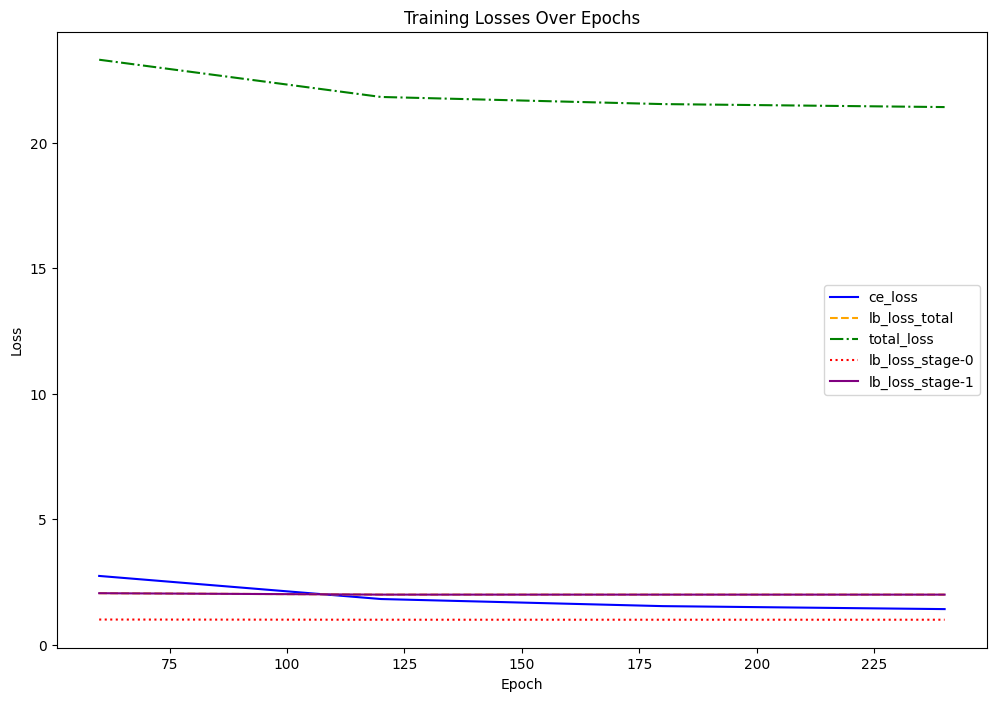

In [22]:
import matplotlib.pyplot as plt

colors = ["blue", "orange", "green", "red", "purple", "brown", "pink"]
linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]


def plot_experiment_logs(experiment_logs):
    epochs = list(experiment_logs.keys())
    to_plot = [
        "ce_loss",
        "lb_loss_total",
        "total_loss",
        "lb_loss_stage-0",
        "lb_loss_stage-1",
    ]
    plt.figure(figsize=(12, 8))
    for metric in to_plot:
        if metric in experiment_logs:
            steps, values = zip(*experiment_logs[metric])
            plt.plot(
                steps,
                values,
                label=metric,
                color=colors[to_plot.index(metric) % len(colors)],
                linestyle=linestyles[to_plot.index(metric) % len(linestyles)],
            )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses Over Epochs")
    plt.legend()
    plt.show


plot_experiment_logs(experiment_logs)

In [23]:
from generate import generate

generated_text = generate(
    model,
    prompt="Sleep Token is",
)

buf = []
token_count = 0
for token in generated_text:
    buf.append(token)
    token_count += 1

    decoded = None
    res = None
    for j in range(1, min(len(buf), 4)):
        try:
            res = tokenizer.decode(buf[:j])
            decoded = j
        except Exception:
            pass

    if res is not None:
        print(res, end="", flush=True)
        buf = buf[decoded:]

    if token_count >= 100:
        print("\n\nBreaking because of token count")
        break

 Making Wal-Mart Australia State Colts Serinon in a ban agreement of stent on Falluja and Palestini

Breaking because of token count


Characters in prompt: "44", Tokens: 45
Test input IDs: tensor([[254,  84, 104, 101,  32, 113, 117, 105,  99, 107,  32,  98, 114, 111,
         119, 110,  32, 102, 111, 120,  32, 106, 117, 109, 112, 115,  32, 111,
         118, 101, 114,  32, 116, 104, 101,  32, 108,  97, 122, 121,  32, 100,
         111, 103,  46]], device='cuda:0')
Stage 0 Boundary Probabilities: [1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0
 1 0 0 1 0 1 0 0]
Stage 0 Boundary Mask: [ True False  True False  True False False False False False  True  True
 False False False False  True False False False  True False  True False
  True False  True False  True False  True  True False  True False  True
 False  True False False  True False  True False False]
Stage 0 Selected Probs: [1.         0.85546875 0.6328125  0.63671875 0.66796875 0.5546875
 0.578125   0.546875   0.7265625  0.7578125  0.6953125  0.5625
 0.53515625 0.546875   0.69921875 0.66015625 0.74609375 0.84765625
 0.5625     0.5       

/tmp/ipykernel_1066552/1782852422.py:96: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


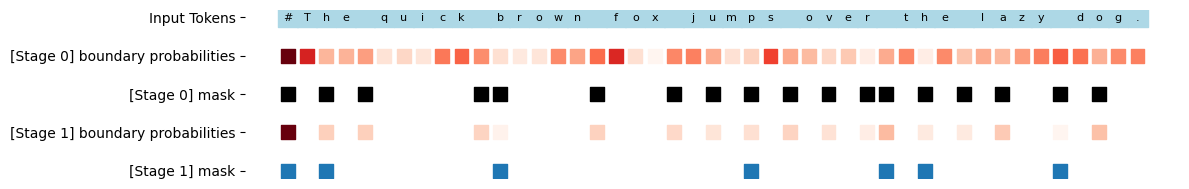

In [77]:
model.eval()

sentence = "The quick brown fox jumps over the lazy dog."
encoded = tokenizer.encode([sentence], add_bos=True)
encoded_ids = encoded[0]["input_ids"]
test_input_ids_BxL = torch.tensor(
    encoded_ids, dtype=torch.long, device=device
).unsqueeze(0)

print(f'Characters in prompt: "{len(sentence)}", Tokens: {len(encoded_ids)}')
print("Test input IDs:", test_input_ids_BxL)

with torch.no_grad():
    mask = torch.ones(test_input_ids_BxL.shape, device=device, dtype=torch.bool)
    output = model.forward(test_input_ids_BxL, mask=mask)
    logits_BxLxV: torch.Tensor = output.logits
    bpred = output.bpred_output

    bpred0_bp = bpred[0].boundary_prob.float().squeeze().cpu().numpy()
    bpred0_bp = np.argmax(bpred0_bp, axis=-1)
    brped0_bm = bpred[0].boundary_mask.squeeze().cpu().numpy()
    bpred0_sp = bpred[0].selected_probs.squeeze().float().cpu().numpy()
    bpred1_bp = bpred[1].boundary_prob.squeeze().float().cpu().numpy()
    bpred1_bp = np.argmax(bpred1_bp, axis=-1)
    brped1_bm = bpred[1].boundary_mask.squeeze().cpu().numpy()
    bpred1_sp = bpred[1].selected_probs.squeeze().float().cpu().numpy()

    print("Stage 0 Boundary Probabilities:", bpred0_bp)
    print("Stage 0 Boundary Mask:", brped0_bm)
    print("Stage 0 Selected Probs:", bpred0_sp)
    print("Stage 1 Boundary Probabilities:", bpred1_bp)
    print("Stage 1 Boundary Mask:", brped1_bm)
    print("Stage 1 Selected Probs:", bpred1_sp)

    print("Logits shape:", logits_BxLxV.shape)
    print(
        f"Shapes - bpred0_bp: {bpred0_bp.shape}, brped0_bm: {brped0_bm.shape}, bpred1_bp: {bpred1_bp.shape}, brped1_bm: {brped1_bm.shape}"
    )
    print(
        f"Mask==1 in bpred0_bp: {(brped0_bm == 1).sum()}, Mask==1 in bpred1_bp: {(brped1_bm == 1).sum()}"
    )

    # Let's create a plot
    # first line is the input tokens (characters)
    # second line are small squares representing stage 0 boundary masks, white for 0, black for 1
    # third line are small squares representing stage 1 boundary masks, white for 0, black for 1
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(figsize=(12, 2))

    sentence_vis = "#" + sentence
    tokens = encoded_ids
    ax.scatter(
        range(len(tokens)),
        [1] * len(tokens),
        c="lightblue",
        s=200,
        label="Input Tokens",
        marker="s",
    )
    # add text labels for input tokens
    for i, char in enumerate(sentence_vis):
        ax.text(i, 1, char, ha="center", va="center", fontsize=8)
    ax.scatter(
        range(len(bpred0_sp)),
        [0.75] * len(bpred0_sp),
        c=bpred0_sp,
        cmap="Reds",
        s=100,
        label="Stage 0 Boundary probabilities",
        marker="s",
    )
    ax.scatter(
        range(len(brped0_bm)),
        [0.5] * len(brped0_bm),
        c=brped0_bm,
        cmap="gray_r",
        s=100,
        label="Stage 0 Boundary mask",
        marker="s",
    )

    indices = np.where(brped0_bm == 1)[0]
    indices_sel = indices[brped1_bm]
    print(f"Indices where Stage 0 Boundary Mask == 1: {indices_sel}")
    ax.scatter(
        indices,
        [0.25] * len(indices),
        c=bpred1_sp,
        s=100,
        label="Stage 1 Boundary Probabilities",
        marker="s",
        cmap="Reds",
    )
    ax.scatter(
        indices_sel,
        [0.0] * len(indices_sel),
        cmap="gray_r",
        s=100,
        label="Stage 1 Boundary Mask",
        marker="s",
    )
    # ax.scatter(
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(
        [
            "[Stage 1] mask",
            "[Stage 1] boundary probabilities",
            "[Stage 0] mask",
            "[Stage 0] boundary probabilities",
            "Input Tokens",
        ]
    )

    # ax.legend()
    # turn off all spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    # turn off xticks
    ax.set_xticks([])
    plt.tight_layout()
    plt.show()